# Inference for NYC T2 using pretrained models

The code to train the models are found here: /downscaling/models
The pretrained models are found are found here: /downscaling/results/ 

Example model path:
```
# Example model path (don't need to specifically point to the saved_model.pb file, just the directory that holds it)
model_path = "/home/gvaillant1/downscaling/results/T2-Tristate-Model/best_model"

# Load the trained model
model = tf.keras.models.load_model(model_path)
```

# Load Libraries

In [8]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

In [10]:
model_path = '/home/gvaillant1/downscaling/pretrained-models/T2-NYC-Model/best_model' 
model = tf.keras.models.load_model(model_path)

#model.summary()

In [11]:
nam_train = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_train_data.nc')
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/train/uWRF_final_01-02.nc')

T2_hr_train = uwrf_train.T2
#------------------------------------------------
#Low resolution (NAM) data
T2_lr_train = nam_train.T2

T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  
#-------------------------------------------------
#Low resolution (NAM)
x_train = T2_scaler_train.transform(T2_lr_train)



In [12]:
x_train = x_train.expand_dims(dim='channel', axis=-1)
x_train.shape

(1537, 5, 5, 1)

In [13]:
# Run the predictor with the loaded model
pred1 = dds.Predictor(
    model, 
    x_train, 
    scale=4, 
    batch_size=4,
    scaler=T2_scaler_train,
    return_lr=False,
    device='CPU'
)

# Generate predictions
unscaled_x_pred = pred1.run()  # Remove coarsened_array1



--------------------------------------------------------------------------------
Starting time: 2025-02-14 16:39:35
--------------------------------------------------------------------------------
385/385 [==============================] - 1s 3ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:01.530947
--------------------------------------------------------------------------------


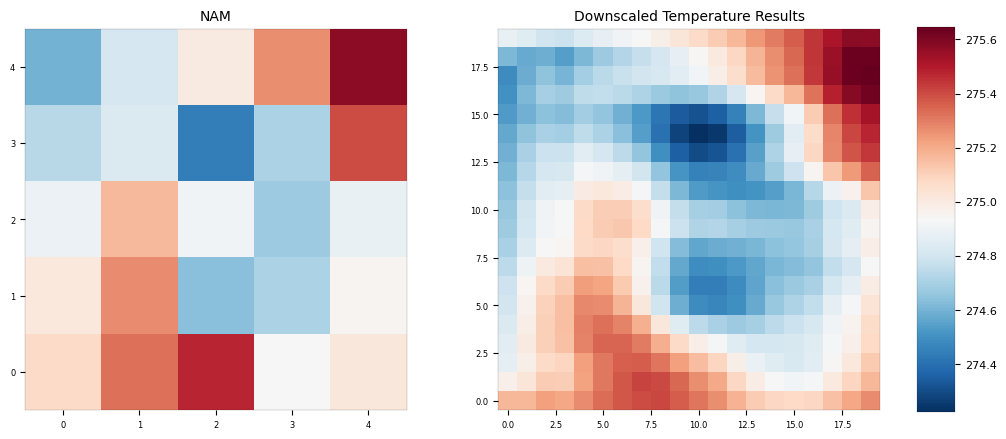

In [14]:
unscaled_x_train = T2_scaler_train.inverse_transform(x_train)
ecv.plot((unscaled_x_train[100].values, unscaled_x_pred[100]), show_coastline = True,
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Temperature Results'))

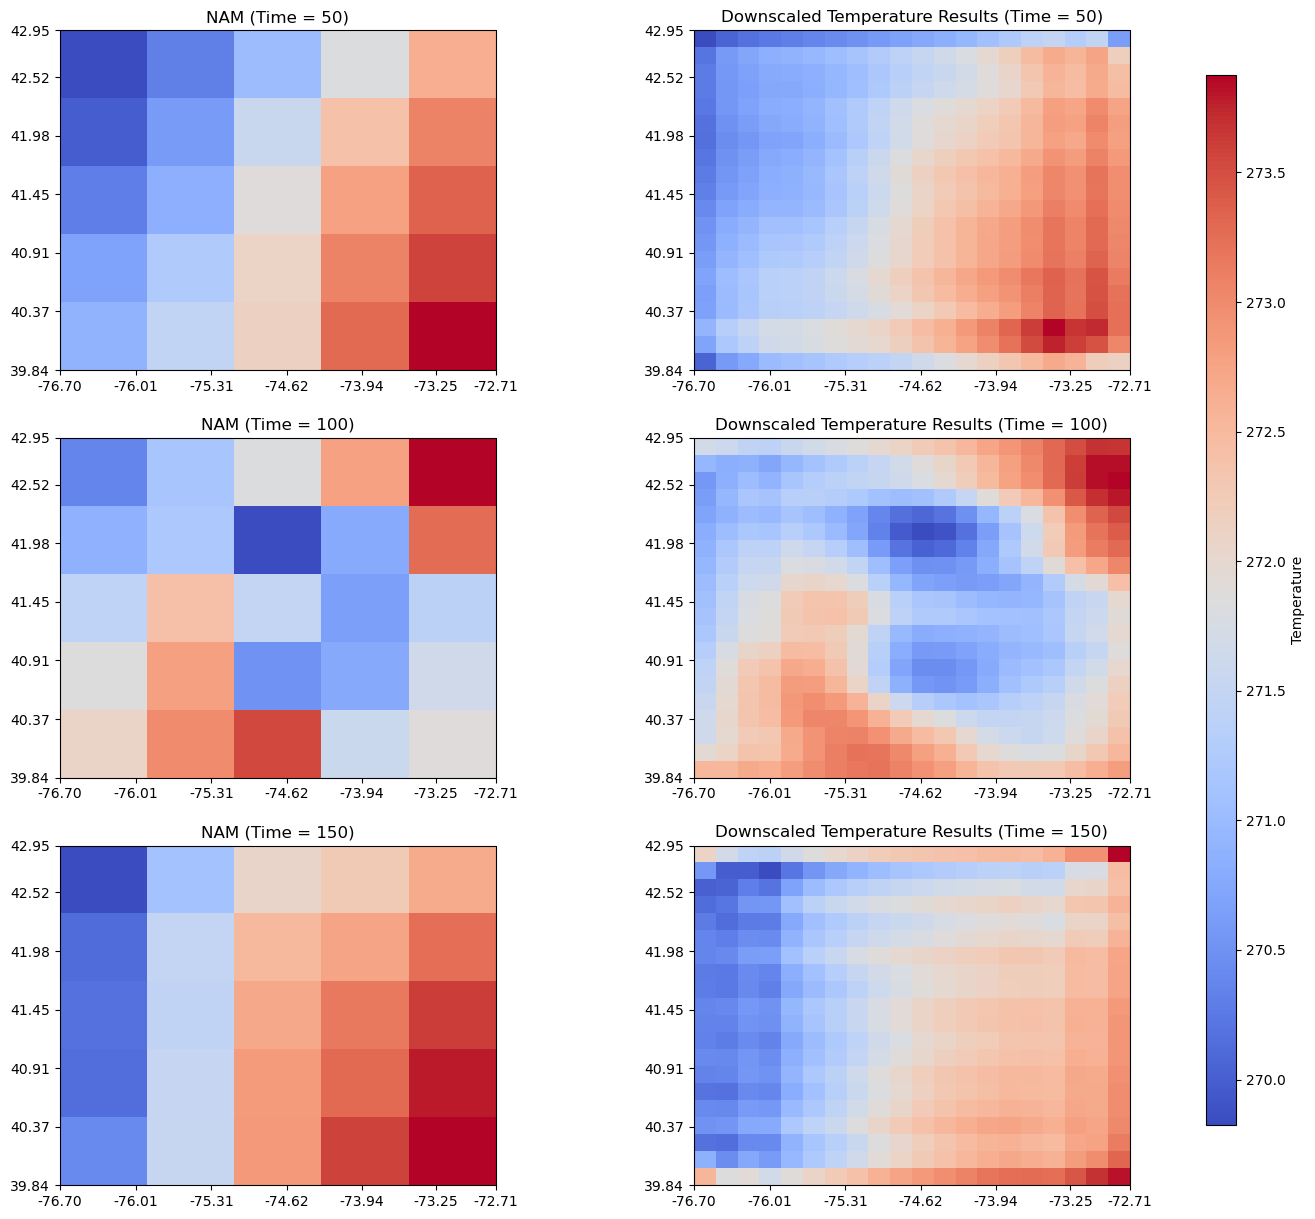

In [15]:
#Only problem here is that the coastlines are not where they should be plotted!
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Latitude and longitude for NAM
nam_lat = np.array([39.83631 , 39.943615, 40.05092 , 40.158245, 40.265556, 40.372875,
       40.480194, 40.587536, 40.69487 , 40.802197, 40.90954 , 41.016872,
       41.12421 , 41.23156 , 41.338894, 41.44624 , 41.553577, 41.660915,
       41.768246, 41.875576, 41.982914, 42.09025 , 42.19757 , 42.304882,
       42.41221 , 42.51952 , 42.626823, 42.73413 , 42.84143 , 42.948727])
nam_lon = np.array([-76.70499 , -76.56531 , -76.42578 , -76.28638 , -76.147095, -76.007965,
       -75.86896 , -75.7301  , -75.59137 , -75.45282 , -75.31436 , -75.176056,
       -75.03787 , -74.89984 , -74.76196 , -74.62421 , -74.48663 , -74.34918 ,
       -74.21185 , -74.07468 , -73.93765 , -73.80078 , -73.66403 , -73.527466,
       -73.39099 , -73.2547  , -73.11856 , -72.982544, -72.84671 , -72.711])

#extra lat: 40.93637, 40.963203, 40.99004
#extra lon: -73.66403, -73.62988, -73.5957

nam_lon_grid, nam_lat_grid = np.meshgrid(nam_lon, nam_lat)


# Dynamically set rows to match the number of time steps
time_steps = [50, 100, 150]
num_time_steps = len(time_steps)
fig, axes = plt.subplots(num_time_steps, 2, subplot_kw={'projection': ccrs.LambertConformal()}, figsize=(15, 5 * num_time_steps))
titles = ['NAM', 'Downscaled Temperature Results']


for t_idx, i in enumerate(time_steps):
    
    nam_data = unscaled_x_train[i].values  # NAM data
    downscaled_data = unscaled_x_pred[i]  # Downscaled data

    # Loop through datasets for the current time step
    for j, (data, title) in enumerate(zip([nam_data, downscaled_data], titles)):
        ax = axes[t_idx, j] if num_time_steps > 1 else axes[j]  # Handle single-row case
        
            # Plot NAM data using imshow
        im = ax.imshow(data[::-1, :], extent=[nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()], 
                       transform=ccrs.LambertConformal(), cmap='coolwarm', origin='upper')



        xticks = [nam_lon[0]] + list(nam_lon[5::5]) + [nam_lon[-1]]
        yticks = [nam_lat[0]] + list(nam_lat[5::5]) + [nam_lat[-1]]

        
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        
        ax.set_xticklabels([f"{lon:.2f}" for lon in xticks])
        ax.set_yticklabels([f"{lat:.2f}" for lat in yticks])  

        ax.set_title(f"{title} (Time = {i})")
        ax.coastlines(resolution='10m', color='black', linewidth=1.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent([nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()], crs=ccrs.LambertConformal())

        
# Add a single colorbar for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Colorbar position
fig.colorbar(im, cax=cbar_ax, label='Temperature')



plt.show()